# ***CloudPhysician***
# ***THE VITAL EXTRACTION CHALLENGE***

### ***Extracting Patient Vitals from the given image of vital sign monitor using ML model, Image Processing and Optical Character Recognition.***

## ***About the data***

- The data consists of various images of health monitors. The classification dataset of the 4 types of monitors was used. Python code was used to randomly shuffle the images and pick 800 for training, and 200 for validation.
The script created the following folder format: 
dataset - images - (train + val folders)
        - labels - (train + val folders)
All the image and label filenames are indexed by numbers. The various label files contain annotations for the images. An example annotation is:
```
0 0.78359375 0.14375 0.065625 0.09583333333333334
3 0.89921875 0.25416666666666665 0.0453125 0.06944444444444445
4 0.794140625 0.5027777777777778 0.08515625 0.10277777777777777
5 0.778515625 0.6208333333333333 0.05546875 0.10277777777777777
6 0.34765625 0.37083333333333335 0.678125 0.09166666666666666
7 0.34765625 0.6201388888888889 0.6734375 0.08472222222222223
8 0.348046875 0.5090277777777777 0.67578125 0.10694444444444444
```

- The first index is the label, and the 4 indices that follow are the normalized bounding box coordinates.
The labels correspond to the indices of the matrix `['HR','SBP','DBP','MAP','SPO2','RR','HR_W','RR_W','SPO2_W']`

- A dataset.yaml file is used to configure the model. It's format is:

```
path: dataset
train: images/train
val: images/val

nc: 9

names: `['HR','SBP','DBP','MAP','SPO2','RR','HR_W','RR_W','SPO2_W']`

```
## ***Getting Started***

To use the model, just run the corresponding cells in the Jupyter notebook. The cells will download the pretrained model from GitHub, and use it to generate the bounding boxes which will later be used for OCR detection.

## ***Neural Network Architecture***

The bounding boxes will also be generated using the yolov5 model:



***Why this architecture?***

YOLOv5 (You Only Look Once version 5) is an object detection model used in computer vision tasks. It is a fast and accurate model that can perform object detection in real-time. YOLOv5 is the latest version in the YOLO series and is based on a single shot multi-box detection (SSD) architecture. It uses anchor boxes to predict bounding boxes for objects in an image and assigns a class label to each bounding box. YOLOv5 is known for its ability to detect objects in real-time and its relatively low computational requirements compared to other object detection models.





Other architectures like the Faster-RCNN and SSD were tried, but the YoloV5 model was found to give the best (and fastest) results. Yolov5 allows us to use a state of the art architecture to quickly detect objects. The model was trained for the problem specification by using the custom dataset. 

## ***Training the model***
The model was trained for 30 epochs and the following table was obtained:


|Class   |  Images | Instances  |     P    |      R    |  mAP50   |  mAP50-95: 100% 10/10  |
| ------ | ------- | ---------- | -------- | --------- | -------- | ---------------------- |
|all     |   300   |    2161    |  0.783   |   0.957   |   0.837  |      0.669             |
|HR      |   300   |     300    |  0.985   |       1   |   0.995  |      0.886             |
|SBP     |   300   |     273    |      1   |   0.867   |   0.989  |      0.842             |
|DBP     |   300   |     269    |  0.757   |       1   |   0.985  |      0.816             |
|MAP     |   300   |     271    |   0.98   |       1   |   0.995  |      0.718             |
|SPO2    |   300   |     281    |  0.762   |       1   |   0.988  |       0.88             |
|RR      |   300   |     298    |  0.988   |   0.835   |    0.98  |      0.829             |
|HR_W    |   300   |     163    |  0.539   |   0.994   |    0.54  |      0.379             |
|RR_W    |   300   |     160    |  0.541   |   0.988   |   0.573  |      0.342             |
|SPO2_W  |   300   |     146    |  0.492   |   0.932   |   0.494  |       0.33             |



## ***Output of ML Model***

Now, the best model was used to create bounding boxes for the various classes:<br>

It outputs two matrices:
- 1 dimensional matrix containing the labels of the predicted classes
- 2 dimensional matrix, containing the bounding box coordinates (normalised x and y, width and height) and confidence for the predicted labels
The predicted bounding boxes can also be displayed using `results.show()`

The two matrices are processed and used later for OCR detection.

## ***Processing of Image***

- Using the bounding box coordinates image is cropped.
- Cropped Image is then denoised using several denoising techniques and thresholded.
- The threshold value chosen is the optimal value where we can binarize the image without losing the text.
- Processed Image is then passed through OCR to predict the text in the image.
- All the predicted value is reported in the form of python dictionary format.

## ***OCR Configuration***

```
r"--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789/"
```

This is a command-line argument for the Tesseract OCR engine. The arguments are as follows:

- `--psm 8` : Page Segmentation Mode 8 is used to recognize a single digit as an instance of the character class.

- `--oem 3` : The OCR Engine Mode 3 is used, which is a deep learning based recognition system.

- `-c tessedit_char_whitelist=0123456789/` : The character whitelist is set to the numbers 0 to 9, allowing the OCR engine to recognize only these characters.

The command line options are used to configure the behavior of the Tesseract OCR engine for optimal recognition of a specific type of text, in this case, single digits.

## ***HR Wave Digitization***

- The YoloV5 model is predicting the HR Wave and returning the coordinates of the bounding box.
- After that the HR bounding box is cropped to give an image containing the HR for digital ECG analysis.
- The function `digitalECG(path)` first reads an image, scales it, performs noise reduction and thresholding on it to obtain a binary image.
- Then it finds the R peaks in the ECG signal by computing the mean, mode, and R_central_difference of the digitized ECG signal.
- Finally, it plots the digital ECG signal, the thresholded image, and the original image.

# ***Explaining Functions Used***

## ***cropImage(img, normalized_coordinates)*** 
- This function crops an image (2D numpy array `img`) using the normalized coordinates specified in `normalized_coordinates` (a list of 4 values, each representing a fraction of the total image size).
- The function first calculates the width and height of the image using `img.shape[1]` and `img.shape[0]`, respectively.
- Then it extracts a rectangular region of the image, defined by the top-left and bottom-right corners, which are computed by scaling the normalized coordinates by the image size.
- The cropped region is returned as a new 2D numpy array.

## ***crop_Image(img, normalized_coordinates)***
- It is function similar to `cropImage`. It is specifically used to crop image of vital values by increasing the margin of cropped image so that edges of the numbers are not cut and is recognized perfectly for OCR.

## ***text_r(img)***
It is a function that performs optical character recognition (OCR) on an input image "img". The function does the following steps:

- Defines the OCR configuration using the "my_config" variable, which specifies that only digits and "/" should be recognized, and sets the Page Segmentation Mode (psm) to 8 and the OCR Engine Mode (oem) to 3.

- Removes noise from the image using the fastNlMeansDenoisingColored function from OpenCV library.
  
- Converts the image to binary format using the threshold function from OpenCV library.

- Converts the binary image to grayscale using the cvtColor function from OpenCV library.

- Uses the image_to_string function from the Tesseract OCR library to perform OCR on the grayscale image, and returns the recognized text.

## ***hr_wave_detection(img, labels, coords)***
This function takes an image, an array of labels and an array of coordinates as inputs. The function performs the following steps:

- Loops over each label in the input "labels" array.
- If the label is equal to 6, it calls the "crop_image" function to crop the image using the corresponding coordinates in the "coords" array.
- Calls the "cv2_imshow" function to display the cropped image, which is supposed to be the HR waveform.

## ***ocr(img, complete_coords, labels)***
- This function performs optical character recognition (OCR) on an input image `img` using `complete_coords` and `labels` as parameters.
- It creates an output dictionary `output_dict` and uses the reference list `reference` which has labels for the extracted data.
- The function crops the input image using the `crop_image` function and performs text recognition on the cropped image using the `text_r` function.
- The extracted text is stored in the `output_dict` with its corresponding label from the `reference` list.
- The function then returns the `output_dict` after all 6 labels have been processed.

## ***inference(image_path:str)***
It is a function that takes an image file path as an input and returns the result of OCR. The function performs the following steps:

- Calls the "monitor_model" function on the input image to get the locations of text regions in the image.
- Calls the "cropImage" function to crop the image based on the locations of the text regions.
- Calls the "vitals_model" function on the cropped image to get updated locations of the text regions.
- Calls the "ocr" function on the cropped image and the updated text region locations to perform OCR on the image.
- Returns the result of OCR.

In [ ]:
!python -m pip install --upgrade pip
!pip install pytesseract
!pip install tensorflow==2.3.1 
!sudo apt-get install tesseract-ocr
!pip install tensorboard==2.4.1
!pip install torch  
!pip uninstall PIL
!pip uninstall Pillow
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 42.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
   

In [ ]:
%matplotlib inline
import pytesseract as tess
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import torch 
from IPython.display import Image
import statistics as st
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15070, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 15070 (delta 25), reused 30 (delta 13), pack-reused 15019
Receiving objects: 100% (15070/15070), 14.13 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (10324/10324), done.


In [ ]:
!git clone https://github.com/FaizanRasoolQ/VitalSIgnExtraction.git

Cloning into 'VitalSIgnExtraction'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), 25.09 MiB | 8.12 MiB/s, done.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.4 MB/s eta 0:00:00


In [ ]:
monitor_model = torch.hub.load('/content/yolov5/', 'custom', path='/content/VitalSIgnExtraction/monitor_best.pt', source='local') 

YOLOv5 🚀 v7.0-80-gc3c8e71 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
def cropImage(img, normalized_coordinates):
  img_width, img_height = img.shape[1],img.shape[0]
  return img[int(normalized_coordinates[0][1]*img_height):int(normalized_coordinates[0][3]*img_height), int(normalized_coordinates[0][0]*img_width):int(normalized_coordinates[0][2]*img_width)]


In [ ]:
vitals_model = torch.hub.load('/content/yolov5', 'custom', path='/content/VitalSIgnExtraction/vitalsign_best.pt', source='local') 

YOLOv5 🚀 v7.0-80-gc3c8e71 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7034398 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
def text_r(img):
    my_config = r"--psm 11 --oem 3 -c tessedit_char_whitelist=0123456789/"
    noise_reduced = cv.fastNlMeansDenoisingColored(img, None, 5, 10, 7, 21)
    thresh, t_img = cv.threshold(noise_reduced, 200, 255, cv.THRESH_BINARY_INV)
    t_img = cv.cvtColor(t_img, cv.COLOR_BGR2GRAY)
    height, width, chaneels = img.shape
    text = tess.image_to_string(t_img, config= my_config)
    return text

In [ ]:
def crop_Image(img, normalized_coordinates):
    margin = 0
    new_img = img[(int(normalized_coordinates[1]*img.shape[0])):(int(normalized_coordinates[3]*img.shape[0])), int(normalized_coordinates[0]*img.shape[1]):int(normalized_coordinates[2]*img.shape[1])]
    return img[(int(normalized_coordinates[1]*img.shape[0]-margin*new_img.shape[0])):(int(normalized_coordinates[3]*img.shape[0]+margin*new_img.shape[0])), int(normalized_coordinates[0]*img.shape[1]-margin*new_img.shape[1]):int(normalized_coordinates[2]*img.shape[1]+margin*new_img.shape[1])]

In [ ]:
def hr_wave_detection(img):
  result=monitor_model(img)
  labels, cord_thres = result.xyxyn[0][:, -1].cpu().numpy(), result.xyxyn[0][:, :-1].cpu().numpy()
  new_image = cropImage(img, cord_thres)
  vital_results=vitals_model(new_image)
  labels, cord_thres = vital_results.xyxyn[0][:, -1].cpu().numpy(), vital_results.xyxyn[0][:, :-1].cpu().numpy()
  #vital_results.show()
  for i in range(len(labels)):
    if(labels[i] == 6):
      hr_wave = crop_Image(new_image, cord_thres[i])
      cv2_imshow(hr_wave)
      return hr_wave

In [ ]:
def ocr(img, complete_coords, labels):
  visited = np.zeros(6)
  refernce = ["HR", "SBP", "DBP", "MAP", "SPO2", "RR"]
  #monitor are the coords of the first out_put
  output_dict = {}
  j = 0
  for i in range(len(labels)):
      if j == 6:
          break
      elif labels[i] < 6 and visited[int(labels[i])] == 0:
              visited[int(labels[i])] = 1
              ind_img = crop_Image(img, complete_coords[i])
              #cv2_imshow( ind_img)
              text = text_r(ind_img)
              text = text.split('\n')
              if len(text)!= 0:
                #print(text[0])
                if text[0]!='\x0c':
                  output_dict[refernce[int(labels[i])]] = text[0]
              j+=1

  return output_dict

In [ ]:
def inference(image_path:str): 
  result=monitor_model(img)
  labels, cord_thres = result.xyxyn[0][:, -1].cpu().numpy(), result.xyxyn[0][:, :-1].cpu().numpy()
  new_image = cropImage(img, cord_thres)
  vital_results=vitals_model(new_image)
  labels, cord_thres = vital_results.xyxyn[0][:, -1].cpu().numpy(), vital_results.xyxyn[0][:, :-1].cpu().numpy()
  #vital_results.show()
  result = ocr(new_image,cord_thres,labels)  
  return result

In [ ]:
import matplotlib.pyplot as plt
def digitalECG(img):
  #Scaling Image
  scale_percent = 300 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  imgr=cv.resize(img, dim, interpolation = cv.INTER_CUBIC)
  #Noise Reduction 
  noise_reduced = cv.fastNlMeansDenoisingColored(imgr, None, 5, 10, 7, 21)
  noise_reduced = cv.cvtColor(noise_reduced, cv.COLOR_BGR2GRAY)
  #Thresholding
  thresh, t_img = cv.threshold(noise_reduced, 175, 255, cv.THRESH_BINARY)
  y,x=t_img.shape
  px = 1/plt.rcParams['figure.dpi']  # pixel in inches
  digitized=np.zeros(x)
  for i in range(x):
      for j in range(y-1,-1,-1):
        if t_img[j,i]==255:
          digitized[i]=j
          break
  min=np.min(digitized[np.nonzero(digitized)])
  max=np.max(digitized)
  mode=st.mode(digitized[np.nonzero(digitized)])
  mean=np.mean(digitized[np.nonzero(digitized)])
  new=np.zeros(x)
  prev_r=-1
  PR_interval=50
  R_central_difference=max-mean
  #Finding R peaks
  for i in range(x):
    if i>0 and (digitized[i]-digitized[i-1])>R_central_difference and (prev_r==-1 or (i-prev_r)>=PR_interval):
      new[i]=1
      prev_r=i
  #Plotting
  plt.rcParams['figure.dpi']=100
  f,axs=plt.subplots(3,1,figsize=(x*px, 6*y*px))
  axs[0].margins(x=0)
  axs[0].plot(range(len(new)),new)
  axs[0].set_title('Digital ECG')
  axs[1].imshow(t_img)
  axs[1].set_title('Thresholded Image')
  axs[2].imshow(imgr)
  axs[2].set_title('Original Image')
  plt.show()
  return new

In [ ]:
img=cv.imread('/content/aveksha_micu_mon--203_2023_1_6_18_0_31.jpeg')
d = inference(img)

In [ ]:
print(d)

{'HR': '04', 'RR': '16'}


In [ ]:
img=cv.imread('/content/hcgranchi_sicu_mon--326_2023_1_2_21_40_3.jpeg')
image= hr_wave_detection(img)
cv.imwrite('hrwave_img.jpeg',image)

True

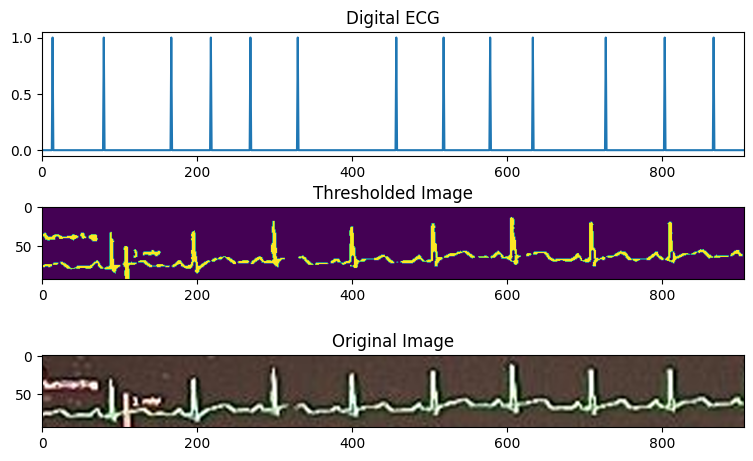

In [ ]:
arr=digitalECG(image)